In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
from operator import add
import collections
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy

In [ ]:
'''IDEIA MUITO BOA

E SE A PONTUACAO DO JOGADOR NAO FOSSE APENAS A SOMA DOS PONTOS TOTAIS? WIN ABOVE AVERAGE OU ALGUMA OUTRA DESSAS METRICAS MANEIRAS DO BASEBALL,
ALGUMA COISA QUE SE UTILIZASSE TAMBEM DO DESV PAD DO CARA (E MELHOR UM CARA CONSTANTE OU UM QUE EXPLODE E MORRE? OU POSSO TER 2 QUE EXPLODEM
NO TIME DESDE QUE EU PREVEJA EXPLOSAO EM SEMANAS DIFERENTES? PROVAVELMENTE DEPENDE DO TAMANHO DA EXPLOSAO TBM)
'''

In [2]:
#importando base de jogadores
#agora ela vai ser uma base fake baseada no ano passado
#na hora do vamos ver, tem que ser a base desse ano
#essa base vai sendo alimentada com as escolhas da galera em tempo real

df_projs=pd.read_pickle('df_projs.pkl')
df_players=pd.read_pickle('df_players.pkl')

In [3]:
#trabalhando a base de projs
df=pd.read_pickle('df_projs.pkl')
df=df_projs[df_projs['season']==2021]
df=df.merge(df_players[['index', 'position', 'full_name']], how='left')
df=df[['index', 'position', 'full_name', 'pts_ppr']]
df['full_name']=np.where(df['full_name'].isna(), df['index'], df['full_name'])
#df=df[['index', 'pts_ppr']]
df=df.groupby(['index', 'position', 'full_name'], as_index=False)['pts_ppr'].sum()
#df=df.groupby(['index', 'position', 'full_name'])['pts_ppr'].sum()
df=df.sort_values('pts_ppr', ascending=False)
df['draft']=0

A seguir, vamos criar o "state" atual, o input do algoritmo

In [26]:
#definindo as posicoes disponiveis
dict_positions={'QB':2, 'RB':3, 'WR':3, 'TE':2, 'FLEX':3, 'K':1, 'DEF':1}

#criando a funcao que, dada a posicao, vai selecionar o melhor jogador disponivel
def selecao(draft, pos):
    top_pos=draft[(draft['position']==pos) & (draft['draft']==0)].head(1)['index'].values[0]
    return top_pos

#criando a funcao que vai de fato selecionar os jogadores
def draft(draft, rooster, player_index, state):
    #draft[draft['index']==player_index]['draft']=1
    draft=draft.set_index('index')
    draft.loc[player_index,'draft']=1
    draft=draft.reset_index()
    rooster.append(player_index)
    pos=draft[draft['index']==player_index]['position'].values[0]
    if pos in ['RB', 'WR', 'TE'] and state[pos]<=0 and state['FLEX']>0:
        state['FLEX']= state['FLEX'] - 1
    else:
        state[pos]= state[pos] - 1

    return draft, rooster, state


#criando o current state
#vamos fazer um dict com os dados que precisamos
#primeiro, inicializar as posicoes
state=dict_positions.copy()
#criando variavel para determinar se eh ida ou volta do draft
state['ida']=1
#puxar o top 30 de cada posicao. Importante pro cara ter uma ideia de quem vai estar disponivel pra frente.
#esse dado na verdade vai estar em % vs media posicao, e % vs media de todas as posicoes, pra medir o valor do cara e da posicao
def get_state(dict_positions, df, state):
    media=df['pts_ppr'].mean()
    for pos in dict_positions:
        if pos=='FLEX':
            continue
        top_pos=df[(df['position']==pos) & (df['draft']==0)].copy()
        media_pos=top_pos['pts_ppr'].mean()
        i=0
        if pos in ['K', 'DEF']:
            limit=10
        else:
            limit=30
        #while i<limit:
        #    state[pos+'_'+str(i)+'_total']=top_pos.iloc[i]['pts_ppr']#/media
            #state[pos+'_'+str(i)+'_pos']=top_pos.iloc[i]['pts_ppr']/media_pos
        #    i=i+1
    #agora vamos transformar em um df
    df_state=pd.DataFrame(state, index=[0])
    return df_state


def init(df):
    dict_positions={'QB':2, 'RB':3, 'WR':3, 'TE':2, 'FLEX':3, 'K':1, 'DEF':1}
    state=dict_positions.copy()
    state['ida']=1
    df['draft']=0
    rooster=[]

    return dict_positions, state, df, rooster




In [5]:
#criando a funcao que vai computar o score do state
#o score vai ser composto pela soma das pontuacoes do time
#impacto negativo demais se faltar jogador de alguma posicao
#impacto bem negativo se tiver muitos jogadores da mesma posicao

def score(state, draft, rooster):
    positions=['QB', 'RB', 'WR', 'TE', 'FLEX', 'K', 'DEF']
    pontos=draft[draft['index'].isin(rooster)]['pts_ppr'].sum()
    falta=0
    sobra=0
    for pos in positions:
        if state[pos]>0:
            falta=falta+1
        elif state[pos]<0:
            sobra=sobra-1
    conta= pontos - 1000000*falta #- 1000*sobra
    return conta

Agora vamos montar a rede neural que vai rodar aqui e dar uma resposta

In [28]:
#criando classe da rede RL
class DQNAgent(torch.nn.Module):
    def __init__(self, params):
        super().__init__()
        self.reward = 0
        self.gamma = 0.9
        self.dataframe = pd.DataFrame()
        self.short_memory = np.array([])
        self.agent_target = 1
        self.agent_predict = 0
        self.learning_rate = params['learning_rate']        
        self.epsilon = 1
        self.actual = []
        self.first_layer = params['first_layer_size']
        self.second_layer = params['second_layer_size']
        self.third_layer = params['third_layer_size']
        self.memory = collections.deque(maxlen=params['memory_size'])
        self.weights = params['weights_path']
        self.load_weights = False
        self.optimizer = None
        self.network()
          
    def network(self):
        # Layers
        self.f1 = nn.Linear(8, self.first_layer)
        self.f2 = nn.Linear(self.first_layer, self.second_layer)
        self.f3 = nn.Linear(self.second_layer, self.third_layer)
        self.f4 = nn.Linear(self.third_layer, 6)
        # weights
        if self.load_weights:
            self.model = self.load_state_dict(torch.load(self.weights))
            print("weights loaded")

    def forward(self, x):
        x = F.relu(self.f1(x))
        x = F.relu(self.f2(x))
        x = F.relu(self.f3(x))
        x = F.softmax(self.f4(x), dim=-1)
        return x

    def remember(self, state, action, reward, next_state, done):
        """
        Store the <state, action, reward, next_state, is_done> tuple in a 
        memory buffer for replay memory.
        """
        self.memory.append((state, action, reward, next_state, done))

    def replay_new(self, memory, batch_size):
        """
        Replay memory.
        """
        if len(memory) > batch_size:
            minibatch = random.sample(memory, batch_size)
        else:
            minibatch = memory
        for state, action, reward, next_state, done in minibatch:
            self.train()
            torch.set_grad_enabled(True)
            target = reward
            next_state_tensor = torch.tensor(np.expand_dims(next_state, 0), dtype=torch.float32).to(DEVICE)
            state_tensor = torch.tensor(np.expand_dims(state, 0), dtype=torch.float32, requires_grad=True).to(DEVICE)
            if not done:
                target = reward + self.gamma * torch.max(self.forward(next_state_tensor)[0])
            output = self.forward(state_tensor)
            target_f = output.clone()
            target_f[0][np.argmax(action)] = target
            target_f.detach()
            self.optimizer.zero_grad()
            loss = F.mse_loss(output, target_f)
            loss.backward()
            self.optimizer.step()            

    def train_short_memory(self, state, action, reward, next_state, done):
        """
        Train the DQN agent on the <state, action, reward, next_state, is_done>
        tuple at the current timestep.
        """
        self.train()
        torch.set_grad_enabled(True)
        target = reward
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32).to(DEVICE)
        state_tensor = torch.tensor(state, dtype=torch.float32, requires_grad=True).to(DEVICE)
        if not done:
            target = reward + self.gamma * torch.max(self.forward(next_state_tensor[0]))
        output = self.forward(state_tensor)
        target_f = output.clone()
        target_f[0][np.argmax(action)] = target
        target_f.detach()
        self.optimizer.zero_grad()
        loss = F.mse_loss(output, target_f)
        loss.backward()
        self.optimizer.step()

In [8]:
def define_parameters():
    params = dict()
    # Neural Network
    params['epsilon_decay_linear'] = 1/500
    params['learning_rate'] = 0.00013629
    params['first_layer_size'] = 100#200    # neurons in the first layer
    params['second_layer_size'] = 50#20   # neurons in the second layer
    params['third_layer_size'] = 20#50    # neurons in the third layer
    params['episodes'] = 250          
    params['memory_size'] = 2500
    params['batch_size'] = 1000
    # Settings
    params['weights_path'] = 'weights/weights.h5'
    params['train'] = True
    params["test"] = False
    params['plot_score'] = False
    params['log_path'] = 'logs/scores_' +'.txt'
    return params


In [29]:
#Testando rodar o RL. Primeiro, vamos testar se ele seleciona os 12 melhores jogadores disponiveis, sem dialogar com ngm

params= define_parameters()
agent = DQNAgent(params)
agent.optimizer = optim.Adam(agent.parameters(), weight_decay=0, lr=params['learning_rate'])
counter_selection = 0
score_plot = []
counter_plot = []
record = 0
total_score = 0
options=list(dict_positions.keys())
options.remove('FLEX')
rooster=[]
DEVICE = 'cpu'
simulations=0
other_rooster=[]
really_all_choices=[]
really_all_rewards=[]
total_sim=500

while simulations<total_sim:

    dict_positions, state, df, rooster = init(df)
    all_choices=[]
    all_states=[]
    all_new=[]

    while counter_selection<15:
                #agent.epsilon is set to give randomness to actions
                agent.epsilon = 1 - (simulations * params['epsilon_decay_linear'])
                
                #get old state
                state_old = get_state(dict_positions, df, state)
                
                #perform random actions based on agent.epsilon, or  choose the action
                if random.uniform(0, 1) < agent.epsilon:
                    final_move = random.choice(options)
                    #print(final_move)
                else:
                    # predict action based on the old state
                    #prediction = agent.model.predict(state_old)
                    #final_move = options[np.argmax(prediction[0])[0]]
                    with torch.no_grad():
                        state_old_tensor = torch.tensor(state_old.to_numpy(), dtype=torch.float32).to(DEVICE)
                        prediction = agent(state_old_tensor)
                        final_move = options[np.argmax(prediction.detach().cpu().numpy()[0])]
                    
                #perform new move and get new state
                player_index=selecao(df, final_move)
                df, rooster, state=draft(df, rooster, player_index, state)
                state_new = get_state(dict_positions, df, state)
                
                #set treward for the new state
                reward = score(state, df, rooster)

                #other player makes his selection, at first randomly
                other_move=random.choice(options)
                other_index=selecao(df, other_move)
                df, other_rooster, not_state = draft(df, other_rooster, player_index, state)

                all_choices.append(final_move)
                all_states.append(state_old)
                all_new.append(state_new)
                counter_selection=counter_selection+1
                
                #train short memory base on the new action and state
    really_all_choices.append(all_choices)
    really_all_rewards.append(reward)
    for i in range(len(all_choices)):
        agent.train_short_memory(all_states[i].to_numpy(), all_choices[i], 0.9**(14-i)*reward, all_new[i].to_numpy(), False)
                
                # store the new data into a long term memory
        #agent.remember(all_states[i].to_numpy(), all_choices[i], reward, state_new.to_numpy(), False)

    score_plot.append(reward)
    simulations=simulations+1
    counter_selection=0
    print(str(round(simulations/total_sim*100,1))+'%', end='\r')
    #print(simulations, ':', state)

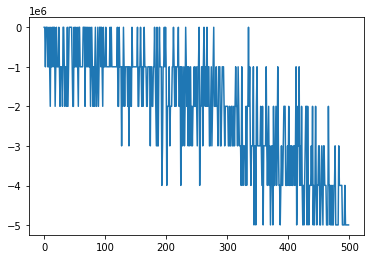

In [30]:
plt.plot(score_plot)

In [31]:
rooster
df_players[df_players['index'].isin(rooster)][['full_name', 'fantasy_positions']]

,full_name,fantasy_positions
1378,Keenan Allen,[WR]
1552,Davante Adams,[WR]
2568,Deebo Samuel,[WR]
3307,Stefon Diggs,[WR]
4497,Diontae Johnson,[WR]
4974,CeeDee Lamb,[WR]
5003,Terry McLaurin,[WR]
5387,DK Metcalf,[WR]
5742,Cooper Kupp,[WR]
6014,Ja'Marr Chase,[WR]


In [19]:
score(state, df, rooster)
really_all_choices

[['DEF',
  'QB',
  'QB',
  'DEF',
  'WR',
  'TE',
  'K',
  'QB',
  'RB',
  'QB',
  'TE',
  'K',
  'TE',
  'DEF',
  'K'],
 ['DEF',
  'WR',
  'RB',
  'DEF',
  'WR',
  'TE',
  'WR',
  'DEF',
  'TE',
  'QB',
  'RB',
  'WR',
  'K',
  'TE',
  'WR'],
 ['TE',
  'WR',
  'WR',
  'QB',
  'RB',
  'DEF',
  'DEF',
  'DEF',
  'RB',
  'DEF',
  'WR',
  'DEF',
  'TE',
  'DEF',
  'TE'],
 ['RB',
  'RB',
  'RB',
  'DEF',
  'QB',
  'DEF',
  'K',
  'WR',
  'QB',
  'QB',
  'WR',
  'RB',
  'WR',
  'QB',
  'TE'],
 ['QB',
  'QB',
  'TE',
  'TE',
  'K',
  'QB',
  'RB',
  'WR',
  'QB',
  'K',
  'QB',
  'WR',
  'WR',
  'RB',
  'WR'],
 ['DEF',
  'TE',
  'K',
  'TE',
  'WR',
  'QB',
  'DEF',
  'K',
  'DEF',
  'WR',
  'WR',
  'WR',
  'RB',
  'WR',
  'WR'],
 ['DEF',
  'WR',
  'DEF',
  'RB',
  'K',
  'RB',
  'TE',
  'TE',
  'TE',
  'QB',
  'WR',
  'K',
  'K',
  'K',
  'RB'],
 ['RB',
  'RB',
  'WR',
  'QB',
  'WR',
  'RB',
  'RB',
  'QB',
  'K',
  'QB',
  'K',
  'DEF',
  'RB',
  'WR',
  'DEF'],
 ['DEF',
  'DEF',
  'QB',


In [ ]:
#FAZ TODAS AS SELECOES SEGUINDO O LOOP NORMAL
#GUARDA OS STATES DE CADA SELECAO
#MAS CALCULA APENAS O SCORE FINAL
#AI SO NO FINAL DO LOOP FAZ A ETAPA DE TREINO, PEGANDO ESSE MESMO VALOR DE REWARD FINAL E JOGANDO PARA TODOS OS STATES
#ACHO QUE PRECISO ADICIONAR A VAR DE QUANTAS ESCOLHAS FALTAM. MAS NAO TENHO CERTEZA

In [ ]:
#state -> vagas para cada posicao; top n de cada posicao; picks a fazer; escolhas ate a proxima
#decisao -> qual posicao pegar (da pra adicionar depois qual rank de qual posicao pegar)
#score -> pontuacao dos jogadores; penalidade absurda se nao preencher todas as posicoes; penalidade se pegar mais de 2 reservas da poiscao (ou mais de 1?)